In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
board_dict = {
    "a" : 1, "b" : 2, "c" : 3, "d" : 4, 
    "e" : 5, "f" : 6, "g" : 7, "h" : 8
}
depth_dict = {
    "zero" : 0, "one" : 1, "two" : 2, "three" : 3,
    "four" : 4, "five" : 5, "six" : 6, "seven" : 7,
    "eight" : 8, "nine" : 9, "ten" : 10, "eleven" : 11,
    "twelve" : 12, "thirteen" : 13, "fourteen" : 14, "fifteen" : 15,
    "sixteen" : 16, "draw" : 17
}
# f = lambda x: np.array([board_dict.get(x[0]), x[1], board_dict.get(x[2]), x[3], board_dict.get(x[4]), x[5], depth_dict.get(x[6])])

In [3]:
# data = np.loadtxt('train.data', delimiter=',', dtype='str')
# data = np.array([f(row) for row in data], dtype=np.float32)

data = pd.read_csv('train.data', names=['wking_file', 'wking_rank', 'wrook_file', 'wrook_rank', 'bking_file', 'bking_rank', 'depth'])

data['wking_file'] = data['wking_file'].apply(lambda x : board_dict.get(x))
data['wrook_file'] = data['wrook_file'].apply(lambda x : board_dict.get(x))
data['bking_file'] = data['bking_file'].apply(lambda x : board_dict.get(x))
data['depth'] = data['depth'].apply(lambda x : depth_dict.get(x))

data.head()

,wking_file,wking_rank,wrook_file,wrook_rank,bking_file,bking_rank,depth
0,4,1,4,5,6,5,14
1,3,2,7,7,5,8,10
2,2,1,6,7,8,7,13
3,3,2,4,1,7,5,13
4,4,1,4,7,7,2,12


<AxesSubplot:xlabel='depth', ylabel='count'>

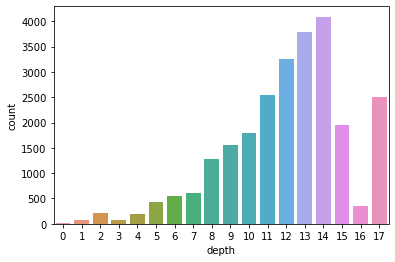

In [4]:
sns.countplot(x = 'depth', data=data)

In [5]:
X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

In [6]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=1)

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [8]:
def get_class_distribution(obj):
    count_dict = {
        "0":0,
        "1": 0,
        "2": 0,
        "3": 0,
        "4": 0,
        "5": 0,
        "6": 0,
        "7": 0,
        "8": 0,
        "9": 0,
        "10": 0,
        "11": 0,
        "12": 0,
        "13": 0,
        "14": 0,
        "15": 0,
        "16": 0,
        "draw": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['0'] += 1
        elif i == 1: 
            count_dict['1'] += 1
        elif i == 2: 
            count_dict['2'] += 1
        elif i == 3: 
            count_dict['3'] += 1
        elif i == 4: 
            count_dict['4'] += 1  
        elif i == 5: 
            count_dict['5'] += 1
        elif i == 6: 
            count_dict['6'] += 1
        elif i == 7: 
            count_dict['7'] += 1
        elif i == 8: 
            count_dict['8'] += 1 
        elif i == 9: 
            count_dict['9'] += 1
        elif i == 10: 
            count_dict['10'] += 1
        elif i == 11: 
            count_dict['11'] += 1
        elif i == 12: 
            count_dict['12'] += 1 
        elif i == 13: 
            count_dict['13'] += 1 
        elif i == 14: 
            count_dict['14'] += 1
        elif i == 15: 
            count_dict['15'] += 1
        elif i == 16: 
            count_dict['16'] += 1
        elif i == 17: 
            count_dict['draw'] += 1              
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

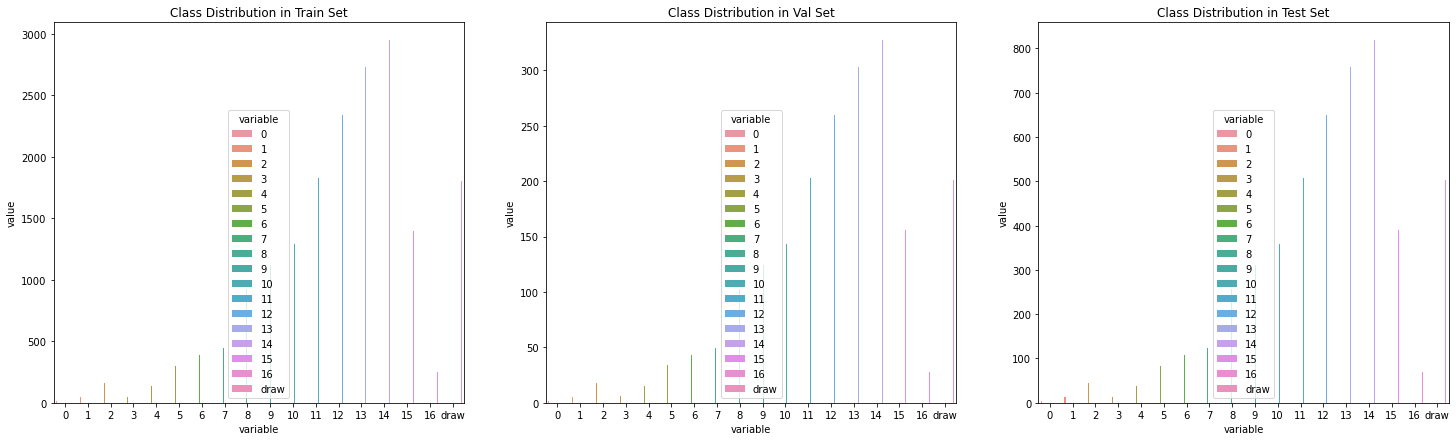

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [10]:
class ChessDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X) 

In [11]:
train_dataset = ChessDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ChessDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ChessDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [12]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [13]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0556, 0.0204, 0.0063, 0.0200, 0.0075, 0.0033, 0.0026, 0.0022, 0.0011,
        0.0009, 0.0008, 0.0005, 0.0004, 0.0004, 0.0003, 0.0007, 0.0039, 0.0006])


In [14]:
class_weights_all = class_weights[target_list]

In [15]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [146]:
EPOCHS = 500
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 18

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

In [115]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 256)        
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 64)      
        self.layer_5 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, num_class) 
        
        self.relu = nn.ReLU()    
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.relu(x)
        
        x = self.layer_3(x)
        x = self.relu(x)
        
        x = self.layer_4(x)
        x = self.relu(x)
        
        x = self.layer_5(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        
        return x

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [142]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.load_state_dict(torch.load(r'C:\Users\diasa\Machine-Learning\King-Rook_vs_King\model_scripted.pt'))
model.eval()
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=6, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_5): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=18, bias=True)
  (relu): ReLU()
)


In [143]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [144]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [150]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()

    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

     # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
        

Begin training.


Epoch 001: | Train Loss: 0.02436 | Val Loss: 0.87620 | Train Acc: 88.418| Val Acc: 68.218
Epoch 002: | Train Loss: 0.02457 | Val Loss: 0.86484 | Train Acc: 88.207| Val Acc: 68.663
Epoch 003: | Train Loss: 0.02467 | Val Loss: 0.90862 | Train Acc: 87.996| Val Acc: 67.921
Epoch 004: | Train Loss: 0.02364 | Val Loss: 1.28441 | Train Acc: 88.621| Val Acc: 59.703
Epoch 005: | Train Loss: 0.08402 | Val Loss: 0.89863 | Train Acc: 83.695| Val Acc: 67.574
Epoch 006: | Train Loss: 0.02640 | Val Loss: 0.87034 | Train Acc: 87.579| Val Acc: 69.554
Epoch 007: | Train Loss: 0.02431 | Val Loss: 0.87272 | Train Acc: 88.618| Val Acc: 69.109
Epoch 008: | Train Loss: 0.02415 | Val Loss: 0.85374 | Train Acc: 88.204| Val Acc: 70.099
Epoch 009: | Train Loss: 0.02550 | Val Loss: 0.89956 | Train Acc: 88.130| Val Acc: 67.723
Epoch 010: | Train Loss: 0.02330 | Val Loss: 0.88800 | Train Acc: 88.730| Val Acc: 68.218
Epoch 011: | Train Loss: 0.02360 | Val Loss: 0.88116 | Train Acc: 88.572| Val Acc: 68.218
Epoch 012:

Epoch 093: | Train Loss: 0.02275 | Val Loss: 0.88156 | Train Acc: 88.916| Val Acc: 68.515
Epoch 094: | Train Loss: 0.02254 | Val Loss: 0.88938 | Train Acc: 89.235| Val Acc: 68.267
Epoch 095: | Train Loss: 0.02546 | Val Loss: 0.86521 | Train Acc: 88.951| Val Acc: 69.752
Epoch 096: | Train Loss: 0.02665 | Val Loss: 0.92596 | Train Acc: 88.119| Val Acc: 67.228
Epoch 097: | Train Loss: 0.02313 | Val Loss: 0.86096 | Train Acc: 88.975| Val Acc: 68.317
Epoch 098: | Train Loss: 0.02155 | Val Loss: 0.86882 | Train Acc: 89.316| Val Acc: 70.000
Epoch 099: | Train Loss: 0.02322 | Val Loss: 0.85619 | Train Acc: 88.846| Val Acc: 69.703
Epoch 100: | Train Loss: 0.02262 | Val Loss: 0.92894 | Train Acc: 88.905| Val Acc: 66.931
Epoch 101: | Train Loss: 0.02542 | Val Loss: 0.87613 | Train Acc: 88.193| Val Acc: 68.317
Epoch 102: | Train Loss: 0.02258 | Val Loss: 0.88734 | Train Acc: 88.733| Val Acc: 68.515
Epoch 103: | Train Loss: 0.02564 | Val Loss: 0.85738 | Train Acc: 88.144| Val Acc: 69.604
Epoch 104:

Epoch 185: | Train Loss: 0.02136 | Val Loss: 0.89219 | Train Acc: 89.372| Val Acc: 68.663
Epoch 186: | Train Loss: 0.02516 | Val Loss: 0.87944 | Train Acc: 88.596| Val Acc: 69.901
Epoch 187: | Train Loss: 0.02031 | Val Loss: 0.85912 | Train Acc: 90.088| Val Acc: 70.693
Epoch 188: | Train Loss: 0.02168 | Val Loss: 0.88547 | Train Acc: 89.579| Val Acc: 69.356
Epoch 189: | Train Loss: 0.02073 | Val Loss: 0.88742 | Train Acc: 89.540| Val Acc: 69.505
Epoch 190: | Train Loss: 0.01997 | Val Loss: 0.87646 | Train Acc: 90.046| Val Acc: 70.149
Epoch 191: | Train Loss: 0.01923 | Val Loss: 0.85422 | Train Acc: 90.042| Val Acc: 71.040
Epoch 192: | Train Loss: 0.02161 | Val Loss: 0.98380 | Train Acc: 89.347| Val Acc: 67.376
Epoch 193: | Train Loss: 0.02289 | Val Loss: 0.86383 | Train Acc: 89.046| Val Acc: 70.693
Epoch 194: | Train Loss: 0.02151 | Val Loss: 0.86447 | Train Acc: 89.586| Val Acc: 70.545
Epoch 195: | Train Loss: 0.02099 | Val Loss: 0.92364 | Train Acc: 89.565| Val Acc: 68.564
Epoch 196:

Epoch 277: | Train Loss: 0.02277 | Val Loss: 1.11932 | Train Acc: 89.186| Val Acc: 63.267
Epoch 278: | Train Loss: 0.03645 | Val Loss: 0.87078 | Train Acc: 87.723| Val Acc: 71.139
Epoch 279: | Train Loss: 0.02001 | Val Loss: 0.85487 | Train Acc: 90.172| Val Acc: 71.386
Epoch 280: | Train Loss: 0.01919 | Val Loss: 0.86553 | Train Acc: 90.523| Val Acc: 70.545
Epoch 281: | Train Loss: 0.01955 | Val Loss: 0.84934 | Train Acc: 90.063| Val Acc: 71.931
Epoch 282: | Train Loss: 0.02016 | Val Loss: 0.88631 | Train Acc: 89.839| Val Acc: 69.059
Epoch 283: | Train Loss: 0.02087 | Val Loss: 0.86567 | Train Acc: 89.544| Val Acc: 70.693
Epoch 284: | Train Loss: 0.01933 | Val Loss: 0.84797 | Train Acc: 90.014| Val Acc: 71.485
Epoch 285: | Train Loss: 0.02007 | Val Loss: 0.86913 | Train Acc: 89.958| Val Acc: 70.891
Epoch 286: | Train Loss: 0.01899 | Val Loss: 0.84647 | Train Acc: 90.263| Val Acc: 71.683
Epoch 287: | Train Loss: 0.04792 | Val Loss: 1.04461 | Train Acc: 86.793| Val Acc: 68.416
Epoch 288:

Epoch 369: | Train Loss: 0.06585 | Val Loss: 0.87787 | Train Acc: 87.396| Val Acc: 71.386
Epoch 370: | Train Loss: 0.01989 | Val Loss: 0.86091 | Train Acc: 90.712| Val Acc: 71.188
Epoch 371: | Train Loss: 0.01877 | Val Loss: 0.86386 | Train Acc: 90.951| Val Acc: 72.129
Epoch 372: | Train Loss: 0.01765 | Val Loss: 0.85822 | Train Acc: 91.046| Val Acc: 72.376
Epoch 373: | Train Loss: 0.01824 | Val Loss: 0.84905 | Train Acc: 90.568| Val Acc: 72.574
Epoch 374: | Train Loss: 0.01811 | Val Loss: 0.84950 | Train Acc: 90.772| Val Acc: 71.782
Epoch 375: | Train Loss: 0.01794 | Val Loss: 0.89675 | Train Acc: 90.621| Val Acc: 70.545
Epoch 376: | Train Loss: 0.01953 | Val Loss: 0.86733 | Train Acc: 90.168| Val Acc: 72.030
Epoch 377: | Train Loss: 0.01928 | Val Loss: 0.85343 | Train Acc: 90.340| Val Acc: 72.228
Epoch 378: | Train Loss: 0.01991 | Val Loss: 0.88787 | Train Acc: 90.168| Val Acc: 70.644
Epoch 379: | Train Loss: 0.02074 | Val Loss: 0.88454 | Train Acc: 89.961| Val Acc: 71.238
Epoch 380:

Epoch 461: | Train Loss: 0.01707 | Val Loss: 0.84557 | Train Acc: 91.523| Val Acc: 72.327
Epoch 462: | Train Loss: 0.01840 | Val Loss: 0.86353 | Train Acc: 91.070| Val Acc: 71.584
Epoch 463: | Train Loss: 0.05643 | Val Loss: 0.97446 | Train Acc: 87.074| Val Acc: 69.307
Epoch 464: | Train Loss: 0.01796 | Val Loss: 0.84032 | Train Acc: 90.716| Val Acc: 73.267
Epoch 465: | Train Loss: 0.01679 | Val Loss: 0.83669 | Train Acc: 91.379| Val Acc: 71.782
Epoch 466: | Train Loss: 0.01648 | Val Loss: 0.84848 | Train Acc: 91.365| Val Acc: 72.822
Epoch 467: | Train Loss: 0.01661 | Val Loss: 0.83711 | Train Acc: 91.505| Val Acc: 72.871
Epoch 468: | Train Loss: 0.01699 | Val Loss: 0.87224 | Train Acc: 91.361| Val Acc: 72.525
Epoch 469: | Train Loss: 0.01728 | Val Loss: 0.86124 | Train Acc: 90.611| Val Acc: 71.386
Epoch 470: | Train Loss: 0.01587 | Val Loss: 0.89758 | Train Acc: 91.846| Val Acc: 71.832
Epoch 471: | Train Loss: 0.01737 | Val Loss: 0.89186 | Train Acc: 91.168| Val Acc: 70.347
Epoch 472:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

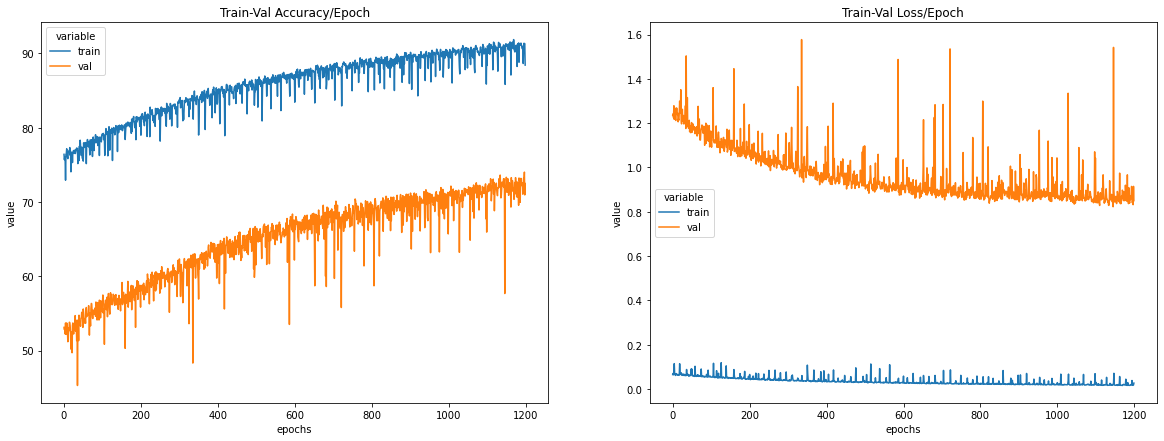

In [153]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [154]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:>

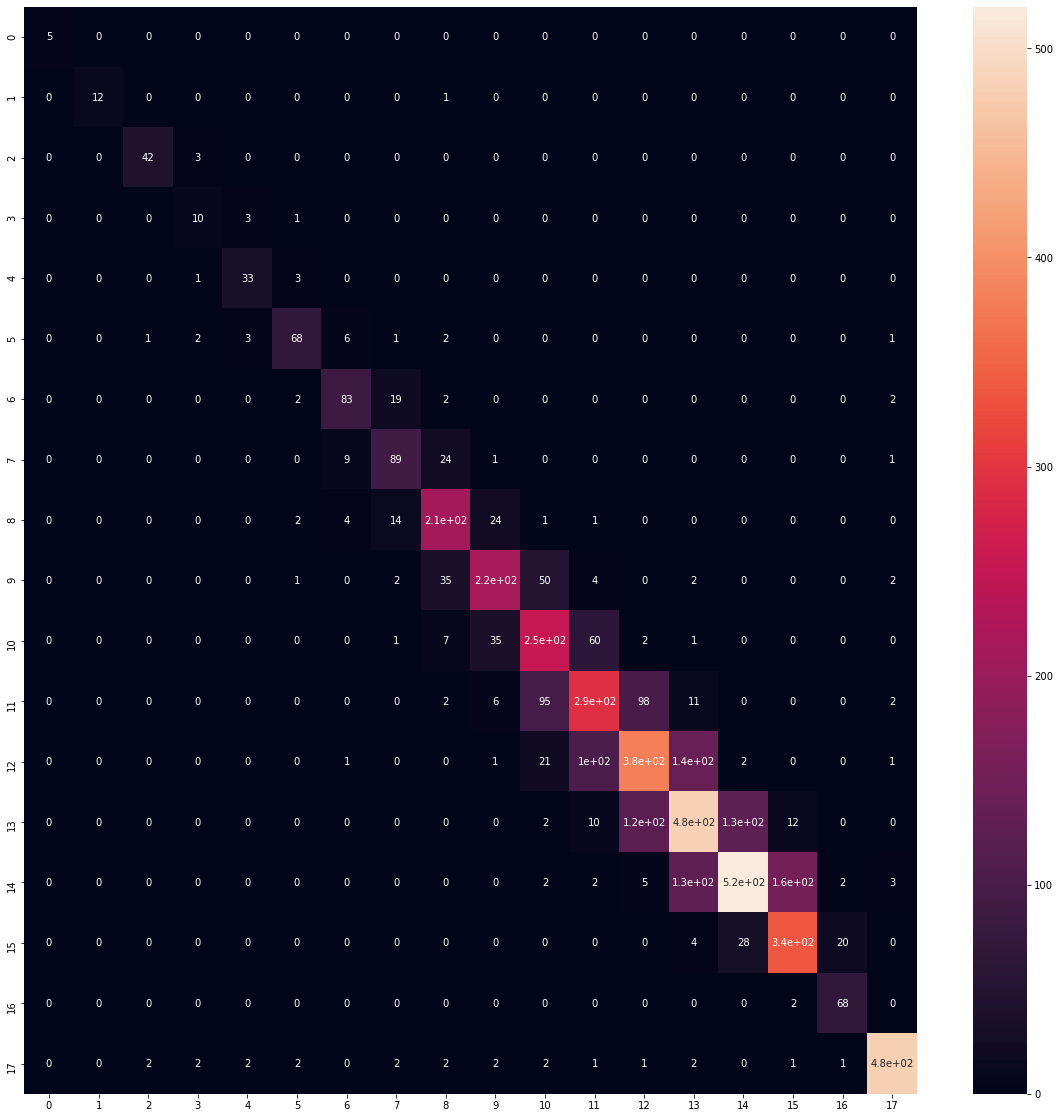

In [155]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

plt.figure(figsize = (20, 20))
sns.heatmap(confusion_matrix_df, annot=True)

In [156]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.92      0.96        13
           2       0.93      0.93      0.93        45
           3       0.56      0.71      0.63        14
           4       0.80      0.89      0.85        37
           5       0.86      0.81      0.83        84
           6       0.81      0.77      0.79       108
           7       0.70      0.72      0.71       124
           8       0.74      0.82      0.78       257
           9       0.76      0.69      0.72       311
          10       0.59      0.70      0.64       359
          11       0.62      0.58      0.60       508
          12       0.62      0.59      0.60       650
          13       0.63      0.64      0.63       757
          14       0.77      0.64      0.70       818
          15       0.66      0.87      0.75       389
          16       0.75      0.97      0.84        70
          17       0.98    

In [151]:
torch.save(model.state_dict(), r'C:\Users\diasa\Machine-Learning\King-Rook_vs_King\model_scripted.pt')